In [2]:
import sys
sys.path.append("H:\chcd_py")
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import scipy.stats as stats
import seaborn as sns
from functools import wraps
from chcd_py.helpers.sql_logger import get_dsn

In [14]:
def profile(fn):
    @wraps(fn)
    def inner(*args, **kwargs):
        fn_kwargs_str = ', '.join(f'{k}={v}' for k, v in kwargs.items())
        print(f'\n{fn.__name__}({fn_kwargs_str})')
        
        t = time.perf_counter()
        retval = fn(*args, **kwargs)
        elapsed = time.perf_counter() - t
        print(f'Time {elapsed:0.4}')
        
        return elapsed
    return inner


@profile
def dx_equal_query(cursor, table, arg):
    '''performs a simple count equal query'''
    cursor.execute(f'select count(*) from {table} where diag_cd = %s', (arg, ))
    return cursor.fetchall()

@profile
def dx_in_query(cursor, table, arg):
    cursor.execute(f'select count(*) from {table} where diag_cd in (%s, %s, %s)', arg)
    return cursor.fetchall()


@profile
def dx_join_query(cursor, table, arg):
    cursor.execute('drop table if exists dev.gm_dx_temp;')
    cursor.execute(f"""
create table dev.gm_dx_temp as 
select * from reference_tables.ref_cms_icd_cm_codes rcicc 
where cd_value like %s ESCAPE ''""", 
                   (arg,))
    cursor.execute(f'''select count(*) from {table} as dx
    inner join dev.gm_dx_temp tmp on dx.diag_cd = tmp.cd_value;''', (arg, ))
    return cursor.fetchall()

def table_comparison_profiler(con, table_list, profile_function, arg_list):
    '''
    con: database connection
    table_list: list of tables that will be compared
    profile_function: function that executes a query; this must return a time elapsed in seconds
    arg_list: list of arguments that will be ran in the query
    '''
    results_dict = {}
    for table in table_list:
        results_dict[table] = []
        for arg in arg_list:
            with con.cursor() as cursor:
                arg = profile_function(cursor, table=table, arg=arg)
                results_dict[table].append(arg)
        
    results_df = pd.DataFrame(results_dict)

    results_melt_df = pd.melt(results_df.reset_index(), id_vars=['index'], 
                              value_vars=table_list)
    results_melt_df.columns = ['index', 'table', 'seconds']
    
    plt.rcParams['figure.figsize'] = [10,5]
    sns.boxplot(x='table',y='seconds',data=results_melt_df)
    
    return results_df

In [5]:
#random codes to compare diagnosis codes

dx_codes = ['05410', 'J050', '2724', 'M79672', '4720', 'Z7982',
            'H4010X1', 'Z3492', 'I10', '6101','F519', 'Z30432',
            'S83412A','C8296', 'K654', 'T8484XA', '4739', 'M5137',
            '49390', 'V0489']

dx_codes_combo = list(itertools.combinations(dx_codes,3))
np.random.shuffle(dx_codes_combo)
dx_codes_combo = dx_codes_combo[:20]

20


In [ ]:
con = psycopg2.connect(get_dsn())
con.autocommit = True


dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=05410)
Time 14.44

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=J050)
Time 18.37

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=2724)
Time 57.25

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=M79672)
Time 51.81

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=4720)
Time 36.12

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=Z7982)
Time 70.56

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=H4010X1)
Time 0.613

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=Z3492)
Time 2.408

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=I10)
Time 81.23

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=6101)
Time 20.56

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=F519)
Time 0.5178

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=Z30432)
Time 9.795

dx_equal_query(table=dw_staging.claim_diag_clean_wc, dx=S83412A)
Time 1.158

dx_equal_query(table=dw_

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
0,14.438907,12.684252,68.403673
1,18.370602,17.067834,68.772425
2,57.254520,49.715985,70.197078
3,51.814114,45.975320,64.172590
4,36.124500,32.872866,69.414517
5,70.562333,61.944922,68.568996
6,0.613036,0.558204,64.256285
7,2.407535,2.295074,68.840304
8,81.233531,66.946374,66.124817
9,20.557466,18.662365,68.943902


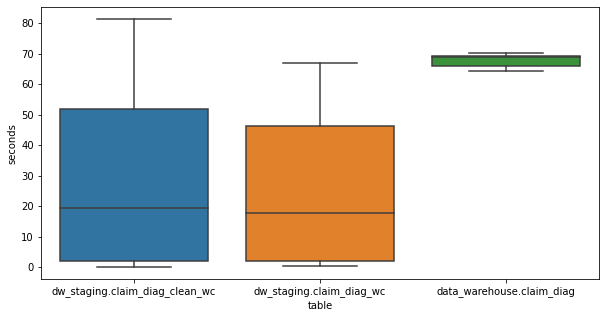

In [10]:

table_list = ['dw_staging.claim_diag_clean_wc', 'dw_staging.claim_diag_wc', 'data_warehouse.claim_diag']

dx_equal_results = table_comparison_profiler(con, table_list, dx_equal_query, dx_codes)
dx_equal_results


dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('2724', 'M79672', '6101'))
Time 68.0

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('I10', '49390', 'V0489'))
Time 77.54

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('2724', '4720', 'Z7982'))
Time 79.14

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('2724', 'M79672', '49390'))
Time 68.78

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('S83412A', 'K654', 'T8484XA'))
Time 30.94

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('2724', 'S83412A', 'K654'))
Time 58.54

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('M79672', 'H4010X1', 'S83412A'))
Time 47.4

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('J050', 'Z30432', 'T8484XA'))
Time 32.3

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('05410', '2724', 'F519'))
Time 53.53

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('J050', 'Z7982', 'T8484XA'))
Time 65.75

dx_in_query(table=dw_staging.claim_diag_clean_wc

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
0,68.000173,57.452954,71.445742
1,77.535587,63.069805,63.023791
2,79.139301,64.634416,64.998080
3,68.775779,57.851421,63.031694
4,30.943704,27.540723,60.710194
5,58.538593,48.417155,62.615259
6,47.397708,40.928183,57.392683
7,32.295093,29.374525,60.639315
8,53.532658,45.810209,63.909294
9,65.747422,56.046744,62.698549


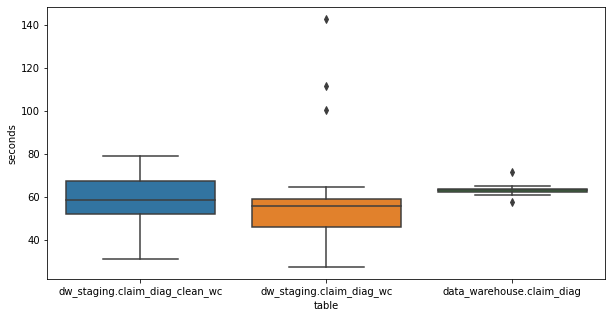

In [15]:

dx_in_results = table_comparison_profiler(con, table_list, dx_in_query, dx_codes_combo)
dx_in_results


dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=054%)
Time 40.53

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=J05%)
Time 18.87

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=272%)
Time 266.6

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=M79%)
Time 1.143e+03

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=472%)
Time 37.86

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=Z79%)
Time 708.4

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=H40%)
Time 122.4

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=Z34%)
Time 185.4

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=I10%)
Time 78.28

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=610%)
Time 46.8

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=F51%)
Time 93.41

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=Z30%)
Time 160.3

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=S83%)
Time 121.5

dx_join_query(table=dw_staging.cla

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
0,40.527351,33.294776,276.238594
1,18.866299,17.632744,282.447176
2,266.634772,226.433359,286.424148
3,1143.159834,977.009190,281.797076
4,37.859457,34.612826,281.571700
5,708.431554,593.530851,269.901749
6,122.379545,107.619601,166.901996
7,185.375518,173.631004,276.022082
8,78.275015,66.329901,296.654901
9,46.802434,40.956350,285.840193


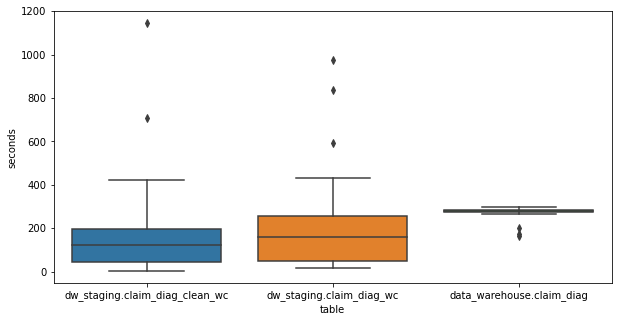

In [16]:
like_dx_codes = [i[:3]+'%' for i in dx_codes]

dx_join_results = table_comparison_profiler(con, table_list, dx_join_query, like_dx_codes)
dx_join_results

In [17]:
dx_join_results.describe()

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
count,20.000000,20.000000,20.000000
mean,203.497361,239.624926,267.279005
std,275.277730,272.194399,37.882733
min,5.874773,16.593962,166.901996
25%,45.233663,49.340106,274.491999
50%,121.925271,160.232491,282.036428
75%,198.876097,258.987575,286.040041
max,1143.159834,977.009190,296.654901


In [18]:

fvalue, pvalue = stats.f_oneway(dx_join_results['dw_staging.claim_diag_clean_wc'], 
                                dx_join_results['dw_staging.claim_diag_wc'], 
                                dx_join_results['data_warehouse.claim_diag'])
print(fvalue, pvalue)

0.40567989126488285 0.6684326068274545
